In [1]:
import time
import sqlite3
import os
import random
import numpy as np
import cupy as cp
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from scipy import interp
from itertools import cycle
from keras.models import Model, Input, load_model
from tensorflow.keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc


#  Data Processing

In [ ]:
gear_defects = [0, 35, 76, 77]

In [2]:
# Image size
size = [300, 400]

In [3]:
# Load pre-processed dataset
X_train = np.load('gears_train_300x400_0,76,77,35.npy')
X_test = np.load('gears_test_300x400_0,76,77,35.npy')
y_train = np.load('gears_ytrain_300x400_0,76,77,35.npy')
y_test = np.load('gears_ytest_300x400_0,76,77,35.npy')

0.5368242263793945


# Training 

In [4]:
# Define dense layer block
def dense_layer(x, filter_num, layer_num):
    layer_configs = {"filters" : filter_num, 
                     "kernel_size" : (3, 3), 
                     "strides" : 1, 
                     "padding" : "same", 
                     "activation" : "relu"}
    dnet_layers = []
    for i in range(2):
        dnet_layer_1 = layers.Conv2D(layer_configs["filters"], 
                                     layer_configs["kernel_size"], 
                                     strides = layer_configs["strides"], 
                                     padding = layer_configs["padding"], 
                                     activation = layer_configs["activation"])(x)
        dnet_layers.append(dnet_layer_1)
    for n in range(2, layer_num):
        dnet_layer_1 = layers.Conv2D(layer_configs["filters"],
                                     layer_configs["kernel_size"], 
                                     strides = layer_configs["strides"], 
                                     padding = layer_configs["padding"], 
                                     activation = layer_configs["activation"])(layers.Concatenate(axis = 3)(dnet_layers))
        dnet_layers.append(dnet_layer_1)
    return dnet_layer_1


In [5]:
# Set up architecture
layer_num = 3
dropout = 0.5
inp = Input(shape = X_train[0].shape)
x = inp
x = layers.Conv2D(4, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
x = dense_layer(x, 16, layer_num)
x = layers.Dropout(dropout)(x)

x = layers.BatchNormalization(axis = 3)(x)
x = dense_layer(x, 16, layer_num)
x = layers.Dropout(dropout)(x)

x = layers.BatchNormalization(axis = 3)(x)
x = dense_layer(x, 16, layer_num)
x = layers.Dropout(dropout)(x)

x = layers.BatchNormalization(axis = 3)(x)
x = dense_layer(x, 16, layer_num)
x = layers.Dropout(dropout)(x)

x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization(axis = 3)(x)

x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(y_train)), activation="softmax")(x)

dense_net = Model(inp, x)
dense_net.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
dense_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 400, 4)  40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 400, 16) 592         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 300, 400, 16) 592         conv2d[0][0]                     
_______________________________________________________________________________________

In [8]:
# Define early stopping and best model checkpoint
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.1, patience=40)
mc = ModelCheckpoint('dnebest_model.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1, save_best_only=True)

In [9]:
# Fitting model with early stopping and checkpoint save
history = dense_net.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/100
262/262 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.8707
Epoch 00001: val_accuracy improved from -inf to 0.75048, saving model to dnebest_model.h5
262/262 [==============================] - 153s 584ms/step - loss: 0.8729 - accuracy: 0.8707 - val_loss: 0.9932 - val_accuracy: 0.7505
Epoch 2/100
262/262 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.8707
Epoch 00002: val_accuracy improved from 0.75048 to 0.78757, saving model to dnebest_model.h5
262/262 [==============================] - 152s 580ms/step - loss: 0.8729 - accuracy: 0.8707 - val_loss: 0.9560 - val_accuracy: 0.7876
Epoch 3/100
262/262 [==============================] - ETA: 0s - loss: 0.8698 - accuracy: 0.8738
Epoch 00003: val_accuracy improved from 0.78757 to 0.80780, saving model to dnebest_model.h5
262/262 [==============================] - 152s 581ms/step - loss: 0.8698 - accuracy: 0.8738 - val_loss: 0.9358 - val_accuracy: 0.8078
Epoch 4/100
262/262 [=======

In [34]:
# Load the best model
dense_net.load_weights('dnebest_model.h5')

In [38]:
dense_net.save("densenet_early_stop.h5")

In [43]:
# Convert the history.history dict to a pandas DataFrame  
hist_df = pd.DataFrame(history.history) 

# Save to json for plots  
hist_json_file = 'densenet_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Metrics

In [35]:
test_loss, test_acc = dense_net.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

65/65 - 6s - loss: 0.9190 - accuracy: 0.8247

Test accuracy: 0.8246628046035767


In [41]:
# Show metrics
predictions = dnebest_model.predict(X_test)
y_pred = predictions.argmax(axis=1).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       166
           1       1.00      0.78      0.88       198
           2       0.81      1.00      0.90      1558
           3       0.00      0.00      0.00       154

    accuracy                           0.82      2076
   macro avg       0.45      0.44      0.44      2076
weighted avg       0.70      0.82      0.76      2076



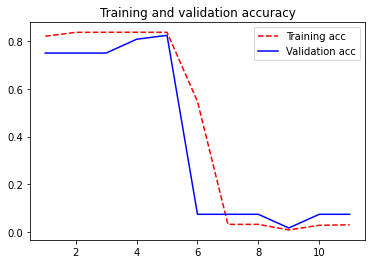

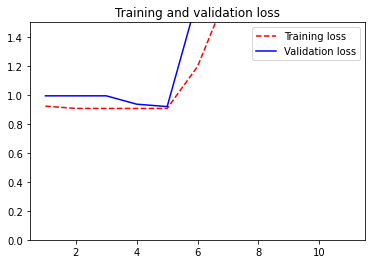

In [37]:
# Plot train and test validation of loss values and accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim([0,1.5])
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
# ROC binary label reshaping
y_pred_roc = (y_pred[:,None] == np.arange(y_pred.max()+1)).astype(int)
y_test_roc = (y_test[:,None] == np.arange(y_test.max()+1)).astype(int)

In [40]:
# Plot ROC
def plot_roc(y_test, y_pred):
    # Plot linewidth.
    lw = 2
    n_classes = len(y_pred_roc[0])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_pred_roc.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_test_roc,y_pred_roc)

ValueError: Found input variables with inconsistent numbers of samples: [8304, 6228]

<AxesSubplot:>

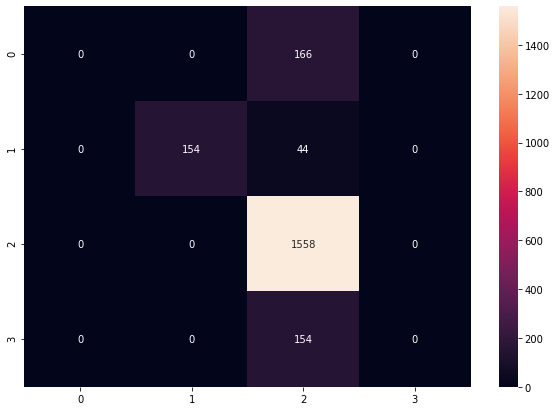

In [42]:
matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(len(np.unique(y_test)))],
                  columns = [i for i in range(len(np.unique(y_test)))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')